# Can we use language used in chat messages to predict student project outcome scores?
By Emma Kelsall 

## Data Processing

In [1]:
pip install spacytextblob

     ------------------------------------- 636.5/636.5 kB 13.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import required Packages 

import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt 
import numpy as np 

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
from sklearn.tree import DecisionTreeClassifier

import statsmodels.formula.api as sm
from scipy.sparse import hstack

import nltk
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

import gensim
from gensim import corpora, models
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize



ModuleNotFoundError: No module named 'gensim'

In [ ]:
# Read CSV file 
chatData = pd.read_csv('VI_data.csv', encoding='latin1')

# We have no interest in predicting Mentor OutcomeScore as these are always 4. 
# If kept in, will create a bias, therefore DROP. 

chatData = chatData[chatData['RoleName'] == 'Player']
chatData
# Drop every column except the chat content, the outcome score and word count
messages = chatData[['userIDs','content', 'OutcomeScore', 'wordCount']]
# reshape dataset
messages = messages.reset_index(drop=True)


# # Create a column for the number of messages each student sent: 
message_counts = messages.groupby("userIDs")["content"].count().reset_index().rename(columns={'content':'messages_sent'})

messages = pd.merge(messages, message_counts, on='userIDs')
messages.head(10)

,userIDs,content,OutcomeScore,wordCount,messages_sent
0,2,Hello I am Brandon!,4,4,65
1,2,Is it imperative to know the answers to the qu...,4,13,65
2,2,Where do we go to start the discussion,4,8,65
3,2,Where do we go to start the discussion?,4,8,65
4,2,I somehow managed to miss the assignment which...,4,30,65
5,2,Well I can tell you that graphs would be helpf...,4,31,65
6,2,I think that one of the least would have to be...,4,12,65
7,2,I think however the cost would be a large fact...,4,12,65
8,2,Cost and reliability was the most important to me,4,9,65
9,2,Well cost greatly affects marketability. If yo...,4,35,65


In [ ]:
# Function to preprocess each chat message in the dataframe  

stopwords = nltk.corpus.stopwords.words('english')
stemmer = nltk.stem.porter.PorterStemmer()

def preprocess_message(chat):
    tokeniser = RegexpTokenizer(r'\w+')
    tokens = tokeniser.tokenize(chat)

    # Lowercase and lemmatise 
    lemmatiser = WordNetLemmatizer()
    lemmas = [lemmatiser.lemmatize(token.lower(), pos='v') for token in tokens]
    
    # Remove stopwords (words deemed insignificant)
    keywords= [lemma for lemma in lemmas if lemma not in stopwords]
    return " ".join(keywords)

In [ ]:
# Create a new column for the processed chat messages 
messages['clean_text'] = messages['content'].apply(preprocess_message)
messages

,userIDs,content,OutcomeScore,wordCount,messages_sent,clean_text
0,2,Hello I am Brandon!,4,4,65,hello brandon
1,2,Is it imperative to know the answers to the qu...,4,13,65,imperative know answer question interview
2,2,Where do we go to start the discussion,4,8,65,go start discussion
3,2,Where do we go to start the discussion?,4,8,65,go start discussion
4,2,I somehow managed to miss the assignment which...,4,30,65,somehow manage miss assignment obviously base ...
...,...,...,...,...,...,...
16897,393,Most definitely.,4,2,72,definitely
16898,393,I will bring the analytical skills and experie...,4,26,72,bring analytical skills experience gain first ...
16899,393,We will discuss the pros and cons of this mate...,4,16,72,discuss pros con material test categories
16900,393,Our attribute maximizes flux rate and reliabil...,4,15,72,attribute maximize flux rate reliability bcr a...


## Exploratory Analysis

In [ ]:
messages

,userIDs,content,OutcomeScore,wordCount,messages_sent,clean_text
0,2,Hello I am Brandon!,4,4,65,hello brandon
1,2,Is it imperative to know the answers to the qu...,4,13,65,imperative know answer question interview
2,2,Where do we go to start the discussion,4,8,65,go start discussion
3,2,Where do we go to start the discussion?,4,8,65,go start discussion
4,2,I somehow managed to miss the assignment which...,4,30,65,somehow manage miss assignment obviously base ...
...,...,...,...,...,...,...
16897,393,Most definitely.,4,2,72,definitely
16898,393,I will bring the analytical skills and experie...,4,26,72,bring analytical skills experience gain first ...
16899,393,We will discuss the pros and cons of this mate...,4,16,72,discuss pros con material test categories
16900,393,Our attribute maximizes flux rate and reliabil...,4,15,72,attribute maximize flux rate reliability bcr a...


Text(0.5, 1.0, 'Top words used by Students during internship')

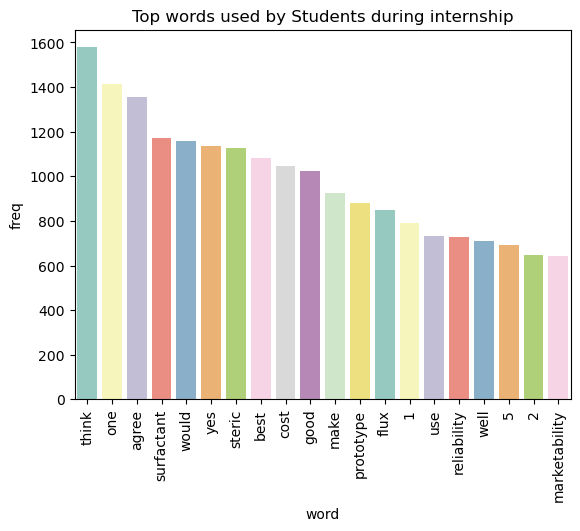

In [ ]:
num_messages = messages.shape[0]

words = []

for index, row in messages.iterrows():
    # split the string in the 'text' column by whitespace and append the resulting list to the word_list
    words.extend(row['clean_text'].split())
    
no_words_set = len(words)

all_words = pd.Series(words)
word_freq = pd.DataFrame(all_words.value_counts())

word_freq = word_freq.rename(columns={0:"term appears"})
word_freq['tf'] = word_freq['term appears']/word_freq.shape[0]

top_20 = word_freq.head(20)

sns.barplot(x=top_20.index, y=top_20['term appears'], palette='Set3')
plt.xticks(rotation = 90)
plt.xlabel('word')
plt.ylabel('freq')
plt.title('Top words used by Students during internship')


In [ ]:
word_freq = word_freq.reset_index()
word_freq = word_freq.rename(columns={'index':'word'})

In [ ]:
word_freq

,word,term appears,tf
0,think,1578,0.370858
1,one,1415,0.332550
2,agree,1357,0.318919
3,surfactant,1170,0.274971
4,would,1158,0.272150
...,...,...,...
4250,indication,1,0.000235
4251,curve,1,0.000235
4252,inferences,1,0.000235
4253,pose,1,0.000235


#### Part-Of-Speech Tagging 

In [ ]:
word_freq['pos_tags']  = word_freq['word'].apply(lambda x: nltk.pos_tag(nltk.word_tokenize(x))[0][1])

nouns = word_freq[word_freq['pos_tags'] == 'NN']
nouns.head(10)
# nouns = [word_freq.index[i] for i in range(len(pos_tags)) if pos_tags[i][1] == 'NN']

word_freq.head(20)

top10_NN = nouns.head(10)['word']

# We'll be using these top 10 most featured nouns to see if they are able to increase
# the accuracy of our model. 

top10_NN

0             think
2             agree
3        surfactant
6            steric
8              cost
11        prototype
12             flux
14              use
15      reliability
19    marketability
Name: word, dtype: object

0.13763014641711357


/var/folders/mx/k0t0r26j3f3f8nz90xg90r_c0000gn/T/ipykernel_2281/2214193643.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  messagesSent = messages.groupby(['userIDs'])['messages_sent', 'OutcomeScore'].mean().reset_index()


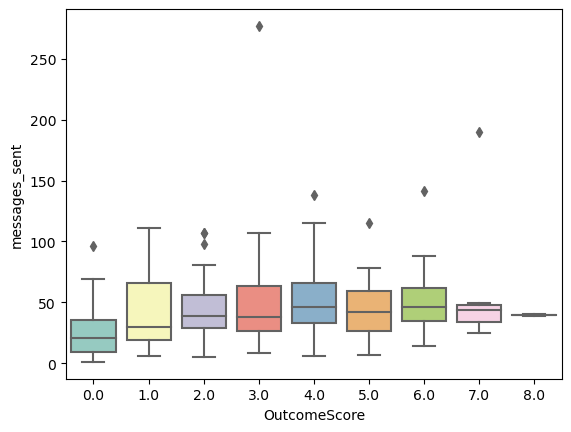

In [ ]:
# Let's see if we can find a correlation  between the number of messages sent and the outcome score

messagesSent = messages.groupby(['userIDs'])['messages_sent', 'OutcomeScore'].mean().reset_index()
messagesSent

sns.boxplot(x='OutcomeScore', y='messages_sent', data=messagesSent, palette='Set3')

corr_coef = messagesSent['OutcomeScore'].corr(messagesSent['messages_sent'])
print(corr_coef)


/var/folders/mx/k0t0r26j3f3f8nz90xg90r_c0000gn/T/ipykernel_2281/2798110433.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  word_count = messages.groupby(['userIDs'])['wordCount', 'OutcomeScore'].mean().reset_index()


0.09591840881501122


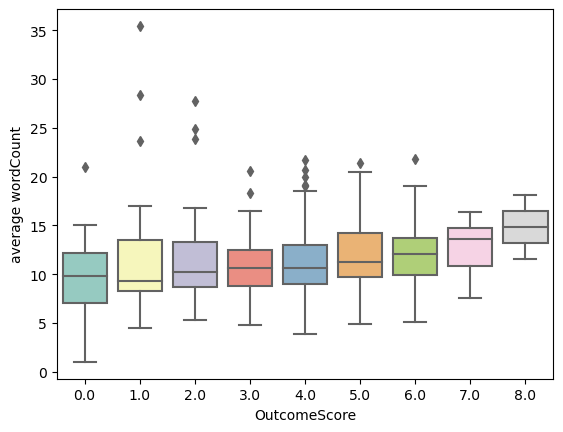

In [ ]:
# What about word count? 

word_count = messages.groupby(['userIDs'])['wordCount', 'OutcomeScore'].mean().reset_index()

sns.boxplot(x='OutcomeScore', y='wordCount', data=word_count, palette='Set3')
plt.ylabel('average wordCount')

corr_coef_WC = word_count['OutcomeScore'].corr(word_count['wordCount'])
print(corr_coef_WC)


## Modelling

#### Types of Models to attempt: 
- Linear Regression
- Logistic Regression
- Random Forest Classification (we are predicting a catergorical variable (9 discrete values) therefore shouldn't use regression)
- Support Vector Machines

#### What features can we use to create these models? 
- TF-IDF (Term Frequency-Inverse Document Frequency)
- Sentiment Analysis
- Word Count 
- Presence of top nouns (by frequency)
- Number of messages sent by students


In [ ]:
# First let's try a simple regression analysis with our 2 variables (WordCount and messages_sent)

reg_mes=sm.ols(formula = 'OutcomeScore ~ messages_sent+wordCount', data= messages).fit()
print(reg_mes.summary())

                            OLS Regression Results                            
Dep. Variable:           OutcomeScore   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     26.32
Date:                Mon, 15 May 2023   Prob (F-statistic):           3.88e-12
Time:                        17:11:10   Log-Likelihood:                -31433.
No. Observations:               16902   AIC:                         6.287e+04
Df Residuals:                   16899   BIC:                         6.290e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         3.5556      0.025    144.128

From the above results we can see that we get a very low R-squared score. This indicates that using messages_sent and wordCount and linear regression was not a good method for predicting OutcomeScore. 

Let's try doing some Natural Language Processing to see what outcome we can get. 

#### Vectorisation


There are 4 different Vectorisation methods that we can use to convert our text data into numbers rather than words. This provides us with something useful for making predictions. 
- TF-IDF Vectorisation
- HashingVectoriser
- Doc2Vec 
- CountVectoriser



In [ ]:
randomState = 42

X = messages['clean_text']
y = messages['OutcomeScore']

#TF-IDF Vectorizer
vectorizer_tf = TfidfVectorizer()
X_vect_tf = vectorizer_tf.fit_transform(X)

#HashingVectoriser
vectorizer_h = HashingVectorizer()
X_vect_h = vectorizer_h.fit_transform(X)


# Doc2Vec
X_cont = messages['content']
documents = [TaggedDocument(words=word_tokenize(text.lower()), tags=[str(i)]) for i, text in enumerate(X_cont)]

model = Doc2Vec(documents, vector_size=100, window=5, min_count=1, workers=4, epochs=20)

doc_vectors = [model.infer_vector(doc.words) for doc in documents]

#CountVectorizer
vectorizer_c = CountVectorizer()
X_vect_c = vectorizer_c.fit_transform(X)



In [ ]:
# Lets try a linear regression, we are predicting categorical data therefore this model will not work!

X_train, X_test, y_train, y_test = train_test_split(X_vect_tf,y, test_size=0.2, random_state=randomState)

lin_model = LinearRegression()

lin_model.fit(X_train, y_train)

y_pred = lin_model.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print(f"accuracy: {accuracy}")
mse = mean_squared_error(y_test, y_pred, squared=False)
print('RMSE:', mse)

RMSE: 1.7564643978749295


As we can see for Linear Regression we get a rmse of 1.756, let's see how it compares to Logistic Regression which is a preferable model for the data we are trying to predict. 

In [ ]:
# Let's create a simple Logistic Regression model using TF-IDF

X_train, X_test, y_train, y_test = train_test_split(X_vect_tf,y, test_size=0.2, random_state=randomState)

tf_model = LogisticRegression(max_iter=1000)

tf_model.fit(X_train, y_train)

y_pred = tf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"accuracy: {accuracy}")
rmse =mean_squared_error(y_test, y_pred, squared=False)
print('RMSE:', rmse)
r2 = r2_score(y_test, y_pred)
print("R^2: %.4f" % r2)



accuracy: 0.35610766045548653
RMSE: 1.6250952694299048
R^2: -0.1068


In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X_vect_h,y, test_size=0.2, random_state=randomState)

# h_model = LogisticRegression(max_iter=1000)

# h_model.fit(X_train, y_train)

# y_pred_h = h_model.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred_h)
# print(f"accuracy: {accuracy}")
# rmse =mean_squared_error(y_test, y_pred_h, squared=False)
# print('RMSE:', rmse)
# r2 = r2_score(y_test, y_pred_h)
# print("R^2: %.4f" % r2)

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(doc_vectors, y, test_size=0.2, random_state=randomState)

doc_model = LogisticRegression(max_iter=1000)

doc_model.fit(X_train, y_train)

y_pred = doc_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"accuracy: {accuracy}")
rmse =mean_squared_error(y_test, y_pred, squared=False)
print('RMSE:', rmse)
r2 = r2_score(y_test, y_pred)
print("R^2: %.4f" % r2)


accuracy: 0.354924578527063
RMSE: 1.5889294620139187
R^2: -0.0581


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_vect_c,y, test_size=0.2, random_state=randomState)

c_model = LogisticRegression(max_iter=1000)

c_model.fit(X_train, y_train)

y_pred_c = c_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_c)
print(f"accuracy: {accuracy}")
rmse =mean_squared_error(y_test, y_pred_c, squared=False)
print('RMSE:', rmse)
r2 = r2_score(y_test, y_pred_c)
print("R^2: %.4f" % r2)

accuracy: 0.3300798580301686
RMSE: 1.745743121887939
R^2: -0.2772


We get an improved rmse score for Logistic Regression when compared to Linear Regression. Indicates that it is a better model to use. However we get a negative R^2 score, which indicates that the model is not fitting the data well at all. Thereforee we should try another model to see if we get a slightly better result. Our doc2vec model also produces the best results.

In [ ]:
# We should also try using a random forest regression approach to test accuracy. 

X_train, X_test, y_train, y_test = train_test_split(X_vect_tf, y, test_size=0.2, random_state=42)

# Train a logistic regression model on the training data
rf_model = RandomForestClassifier(n_estimators=150, max_depth=10)
rf_model.fit(X_train, y_train)

# Evaluate the model on the test data
y_predRF = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_predRF)
print(f"accuracy: {accuracy}")

rmse = mean_squared_error(y_test, y_predRF, squared=False)
print("RMSE: %.4f" % rmse)

r2 = r2_score(y_test, y_predRF)
print("R^2: %.4f" % r2)

accuracy: 0.3581780538302277
RMSE: 1.5753
R^2: -0.0400


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(doc_vectors, y, test_size=0.2, random_state=42)

# Train a logistic regression model on the training data
rf_model = RandomForestClassifier(n_estimators=50, max_depth=10)
rf_model.fit(X_train, y_train)

# Evaluate the model on the test data
y_predRF = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_predRF)
print(f"accuracy: {accuracy}")

rmse = mean_squared_error(y_test, y_predRF, squared=False)
print("RMSE: %.4f" % rmse)

r2 = r2_score(y_test, y_predRF)
print("R^2: %.4f" % r2)

accuracy: 0.3581780538302277
RMSE: 1.5768
R^2: -0.0419


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(doc_vectors, y, test_size=0.2, random_state=42)

# Train a logistic regression model on the training data
rf_model = DecisionTreeClassifier(random_state=42, max_depth=10)
rf_model.fit(X_train, y_train)

# Evaluate the model on the test data
y_predRF = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_predRF)
print(f"accuracy: {accuracy}")

rmse = mean_squared_error(y_test, y_predRF, squared=False)
print("RMSE: %.4f" % rmse)

r2 = r2_score(y_test, y_predRF)
print("R^2: %.4f" % r2)

accuracy: 0.323868677905945
RMSE: 1.7212
R^2: -0.2415


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_vect_h,y, test_size=0.2, random_state=randomState)

rf_model = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_h = h_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_h)
print(f"accuracy: {accuracy}")
rmse =mean_squared_error(y_test, y_pred_h, squared=False)
print('RMSE:', rmse)
r2 = r2_score(y_test, y_pred_h)
print("R^2: %.4f" % r2)

accuracy: 0.3528541851523218
RMSE: 1.6292759363902498
R^2: -0.1125


Using a random forest regression we get an improved RMSE on the one we achieved in the logistic regression. While we don't get a positive R^2 score, it is much closer to zero than in our logistic regression. 

Using the different vectorisation methods, we can see that the doc2vec model has the best accuracy while the tf-idf vectoriser has the best rmse. 

We should use one of these vectorisors in any further calculations. 

#### Sentiment Analysis     

Sentiment analysis is a technique in NLP that involves analysing text in order to determine the sentiment or emotional tone of a text. In this project we use sentiment analysis to classify student's chat messages as positive, negative or neutral, we then use this to determine whether it has an effect on OutcomeScore. 

Sentiment analysis assigns a numerical score to the chat messages

We will use packages spaCy and textblob to find these sentiment scores. .blob.polarity gives us our sentiment/polarity score. It is a score between [-1, 1] where < 0 indicates negative sentiment, > 0 indicates positive sentiment while anything close to 0 indicates neutral sentiment.  

In [ ]:
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('spacytextblob')

def get_sentiment_scores(text):
    doc = nlp(text)
    sentiment = doc._.blob.polarity
    return round(sentiment,2)

messages['sentimentScore'] = messages['clean_text'].apply(get_sentiment_scores)

In [ ]:
messages.head()

,userIDs,content,OutcomeScore,wordCount,messages_sent,clean_text,sentimentScore
0,2,Hello I am Brandon!,4,4,65,hello brandon,0.00
1,2,Is it imperative to know the answers to the qu...,4,13,65,imperative know answer question interview,0.00
2,2,Where do we go to start the discussion,4,8,65,go start discussion,0.00
3,2,Where do we go to start the discussion?,4,8,65,go start discussion,0.00
4,2,I somehow managed to miss the assignment which...,4,30,65,somehow manage miss assignment obviously base ...,-0.43


Accuracy: 0.3498964803312629
RMSE: 1.6106529416825726
R^2: -0.0872


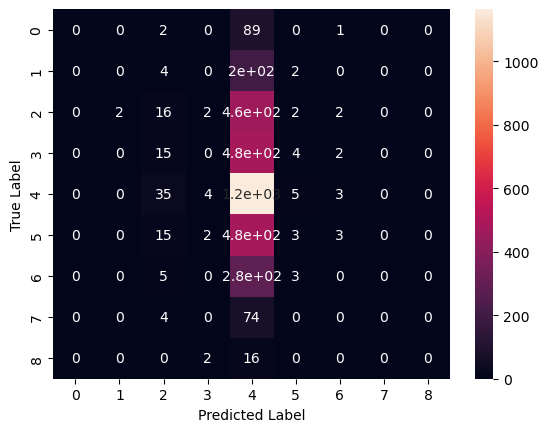

In [ ]:
# X_vect = vectorizer.fit_transform(X)
# X_sentiment = np.column_stack([X_vect.toarray(), messages['sentimentScore']])

X_sentiment = messages[['sentimentScore']]

X_train, X_test, y_train, y_test = train_test_split(X_sentiment, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=150, max_samples=.5).fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred_rf)
print('Accuracy:', acc)


# Evaluate the model using mean squared error
rmse = mean_squared_error(y_test, y_pred_rf, squared=False)
print('RMSE:', rmse)

r2 = r2_score(y_test, y_pred_rf)
print("R^2: %.4f" % r2)


# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Accuracy: 0.35403726708074534
RMSE: 1.600983134804863
R^2: -0.0742


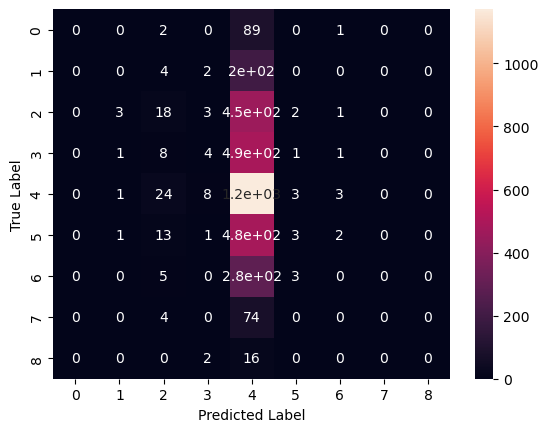

In [ ]:
X_sentiment = messages[['sentimentScore']]

X_train, X_test, y_train, y_test = train_test_split(X_sentiment, y, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier(random_state=42, max_depth=10).fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred_rf)
print('Accuracy:', acc)


# Evaluate the model using mean squared error
rmse = mean_squared_error(y_test, y_pred_rf, squared=False)
print('RMSE:', rmse)

r2 = r2_score(y_test, y_pred_rf)
print("R^2: %.4f" % r2)


# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# from sklearn.svm import SVC

# model = SVC(kernel='poly')
# model.fit(X_train, y_train)

# y_pred = model.predict(X_test)
# acc = accuracy_score(y_test, y_pred)
# print('Accuracy:', acc)

# mse = mean_squared_error(y_test, y_pred, squared=False)
# print("RMSE: %.4f" % mse)

# r2 = r2_score(y_test, y_pred)
# print("R^2: %.4f" % r2)

In [ ]:

# Combine vectorisation with sentiment score
X = pd.concat([pd.DataFrame(X_vect_tf.toarray()), messages['sentimentScore']], axis=1)
X.columns = X.columns.astype(str)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a linear regression model
clf = RandomForestClassifier(n_estimators=50, max_samples=.5).fit(X_train, y_train)

# Evaluate the model on the testing set
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print('Accuracy:', acc)

rmse = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE: %.4f" % rmse)

r2 = r2_score(y_test, y_pred)
print("R^2: %.4f" % r2)

Accuracy: 0.34131913635019223
RMSE: 1.6738
R^2: -0.1741


From the above models we can see that using vectorisation is not a good metric to use to predict OutcomeScore. When paired with sentimentScore, tf-idf vectorisation causes the accuracy to go down and the RMSE to go up which is not what we want. 

#### Keyword Frequency

In the analysis section of this notebook, we extracted the 10 most used nouns by students during their internship. We want to see if using these words leads to a higher outcomeScore. 

In [ ]:
keywords = np.array(top10_NN)

# Let's add the presence of these nouns to our feature matrix
for keyword in keywords:
    messages[f'{keyword}_frequency'] = messages['content'].apply(lambda x: x.count(keyword))

messages.head(7)

,userIDs,content,OutcomeScore,wordCount,messages_sent,clean_text,sentimentScore,think_frequency,agree_frequency,surfactant_frequency,steric_frequency,cost_frequency,prototype_frequency,flux_frequency,use_frequency,reliability_frequency,marketability_frequency
0,2,Hello I am Brandon!,4,4,65,hello brandon,0.00,0,0,0,0,0,0,0,0,0,0
1,2,Is it imperative to know the answers to the qu...,4,13,65,imperative know answer question interview,0.00,0,0,0,0,0,0,0,0,0,0
2,2,Where do we go to start the discussion,4,8,65,go start discussion,0.00,0,0,0,0,0,0,0,0,0,0
3,2,Where do we go to start the discussion?,4,8,65,go start discussion,0.00,0,0,0,0,0,0,0,0,0,0
4,2,I somehow managed to miss the assignment which...,4,30,65,somehow manage miss assignment obviously base ...,-0.43,0,0,0,0,0,0,0,0,0,0
5,2,Well I can tell you that graphs would be helpf...,4,31,65,well tell graph would helpful keep data area t...,0.00,0,0,0,0,0,0,0,0,0,0
6,2,I think that one of the least would have to be...,4,12,65,think one least would marketability,-0.30,1,0,0,0,0,0,0,0,0,0


In [ ]:
# Let's create the Keyword Frequency Matrix that we can use to create our model :) 


X_keywords = messages.iloc[:, 7:17]
X_keywords
y = messages['OutcomeScore']

X_train, X_test, y_train, y_test = train_test_split(X_keywords, y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, )
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_rf)
print('Accuracy:', acc)

rmse = mean_squared_error(y_test, y_pred_rf, squared=False)
print("RMSE: %.4f" % rmse)

r2 = r2_score(y_test, y_pred_rf)
print("R^2: %.4f" % r2)



Accuracy: 0.34131913635019223
RMSE: 1.5877
R^2: -0.0564


In [ ]:
X_keywords = messages.iloc[:, 7:17]
X_keywords
y = messages['OutcomeScore']

X_train, X_test, y_train, y_test = train_test_split(X_keywords, y, test_size=0.2, random_state=42)


clf = DecisionTreeClassifier(max_depth=10, random_state=42).fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_rf)
print('Accuracy:', acc)

rmse = mean_squared_error(y_test, y_pred_rf, squared=False)
print("RMSE: %.4f" % rmse)

r2 = r2_score(y_test, y_pred_rf)
print("R^2: %.4f" % r2)



Accuracy: 0.34131913635019223
RMSE: 1.6036
R^2: -0.0776


In [ ]:
row = {'no_estimators': 150, 'accuracy': accuracy}
for name, score in zip(X_keywords.columns, rf_model.feature_importances_):
    print(name,np.round(score,3))

think_frequency 0.102
agree_frequency 0.062
surfactant_frequency 0.148
steric_frequency 0.097
cost_frequency 0.12
prototype_frequency 0.11
flux_frequency 0.104
use_frequency 0.112
reliability_frequency 0.078
marketability_frequency 0.069


From the above analysis we can see that use of the words 'surfactant' and 'use' had the biggest impact, followed by 'cost'. 'agree' had the smallest impact. 

#### Topic Modelling 

Let's see if we can extract some topics from the chat messages? Will the presence of certain topics lead to a higher accuracy? 



In [ ]:

messages['tokens'] = messages['clean_text'].apply(word_tokenize)

# Create a document-term matrix
dictionary = corpora.Dictionary(messages['tokens'])
doc_term_matrix = [dictionary.doc2bow(doc) for doc in messages['tokens']]

# Train the LDA model
num_topics = 10
lda_model = models.LdaModel(doc_term_matrix, num_topics=num_topics, id2word=dictionary)

# Interpret the topics
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.043*"thank" + 0.042*"surfactant" + 0.041*"think" + 0.039*"best" + 0.020*"one" + 0.020*"attribute" + 0.019*"compare" + 0.018*"surfactants" + 0.018*"well" + 0.017*"result"
Topic: 1 
Words: 0.050*"yeah" + 0.034*"graph" + 0.028*"meet" + 0.026*"way" + 0.020*"data" + 0.019*"internal" + 0.017*"maximize" + 0.015*"correct" + 0.015*"value" + 0.014*"cost"
Topic: 2 
Words: 0.182*"agree" + 0.043*"prototype" + 0.038*"batch" + 0.031*"okay" + 0.024*"one" + 0.023*"create" + 0.021*"everyone" + 0.019*"submit" + 0.019*"let" + 0.015*"make"
Topic: 3 
Words: 0.048*"flux" + 0.047*"good" + 0.045*"reactivity" + 0.044*"blood" + 0.043*"reliability" + 0.039*"cell" + 0.031*"cost" + 0.024*"sound" + 0.024*"marketability" + 0.019*"ok"
Topic: 4 
Words: 0.030*"like" + 0.024*"cost" + 0.023*"see" + 0.021*"work" + 0.020*"tyler" + 0.020*"would" + 0.019*"test" + 0.019*"alright" + 0.018*"sure" + 0.014*"also"
Topic: 5 
Words: 0.049*"one" + 0.048*"make" + 0.040*"good" + 0.030*"right" + 0.022*"need" + 0.022*"d

In [ ]:

topic_probs = pd.DataFrame(columns=['topic_{}'.format(i) for i in range(lda_model.num_topics)])

# Loop over each message and obtain its topic distribution probabilities
for index, row in messages.iterrows():
    message = row['clean_text']
    bow_vector = lda_model.id2word.doc2bow(message.split())
    topic_distribution = lda_model.get_document_topics(bow_vector)
    
    # Fill in the corresponding topic probabilities for the current message
    probs_dict = dict(topic_distribution)
    topic_probs.loc[index] = [probs_dict.get(i, 0.0) for i in range(lda_model.num_topics)]

# Concatenate the topic probabilities DataFrame with the original DataFrame
df_with_topics = pd.concat([messages, topic_probs], axis=1)

In [ ]:
topic_probs

X_train, X_test, y_train, y_test = train_test_split(topic_probs, y, train_size=.8, random_state=42)
# instantatiate the RFC with 100 ensemble members
clf = RandomForestClassifier(n_estimators=50, max_samples=.5, max_depth=10, random_state=42).fit(X_train, y_train)

y_pred = clf.predict(X_test) # calculate the predicted values
accuracy = np.round(accuracy_score(y_test, y_pred),3)
# print the accuracy of the RFC
print('Accuracy {0}'.format(accuracy))

rmse = mean_squared_error(y_test, y_pred, squared=False)
print('RMSE:', mse)

r2 = r2_score(y_test, y_pred)
print("R^2: %.4f" % r2)


Accuracy 0.358
RMSE: 1.7564643978749295
R^2: -0.0402


In [ ]:


X_train, X_test, y_train, y_test = train_test_split(topic_probs, y, train_size=.8, random_state=42)
# instantatiate the RFC with 100 ensemble members
clf = DecisionTreeClassifier(max_depth=10, random_state=42).fit(X_train, y_train)

y_pred = clf.predict(X_test) # calculate the predicted values
accuracy = np.round(accuracy_score(y_test, y_pred),3)
# print the accuracy of the RFC
print('Accuracy {0}'.format(accuracy))

rmse = mean_squared_error(y_test, y_pred, squared=False)
print('RMSE:', mse)

r2 = r2_score(y_test, y_pred)
print("R^2: %.4f" % r2)

Accuracy 0.347
RMSE: 1.7564643978749295
R^2: -0.1396


With this model we get an accuracy score of 0.363, this is the highest accuracy that we've been able to achieve so far, howeveer the RMSE is considerably higher than when we examined keyword frequency and sentiment analysis

This is the best model that we have been able to achieve so far :))) 

Let's try Combining all our features and seeing which features are the best at predicting outcome score 

#### Final Model 

In [ ]:
features = df_with_topics.drop(columns={'OutcomeScore', 'content', 'clean_text', 'userIDs', 'tokens'})
features.head()

# scaler = MinMaxScaler()
# features[['wordCount', 'messages_sent', 'sentimentScore']] = scaler.fit_transform(features[['wordCount', 'messages_sent', 'sentimentScore']])

features


,wordCount,messages_sent,sentimentScore,think_frequency,agree_frequency,surfactant_frequency,steric_frequency,cost_frequency,prototype_frequency,flux_frequency,...,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,4,65,0.00,0,0,0,0,0,0,0,...,0.034904,0.034905,0.034904,0.034917,0.384325,0.336428,0.034904,0.034904,0.034904,0.034904
1,13,65,0.00,0,0,0,0,0,0,0,...,0.019924,0.408087,0.019921,0.019921,0.019921,0.019925,0.019920,0.019926,0.432534,0.019920
2,8,65,0.00,0,0,0,0,0,0,0,...,0.025001,0.025002,0.025005,0.025015,0.025003,0.025005,0.025003,0.025002,0.774962,0.025002
3,8,65,0.00,0,0,0,0,0,0,0,...,0.025002,0.025003,0.025011,0.774939,0.025005,0.025011,0.025007,0.025004,0.025016,0.025003
4,30,65,-0.43,0,0,0,0,0,0,0,...,0.156695,0.000000,0.000000,0.000000,0.566929,0.000000,0.000000,0.000000,0.226337,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16897,2,72,0.00,0,0,0,0,0,0,0,...,0.050012,0.050001,0.050001,0.050001,0.050001,0.050001,0.050001,0.050001,0.549976,0.050007
16898,26,72,0.25,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.193984,0.427507,0.000000,0.324571,0.000000,0.000000
16899,16,72,0.00,0,0,0,0,0,0,0,...,0.476911,0.014287,0.014287,0.014289,0.408785,0.014288,0.014287,0.014290,0.014289,0.014287
16900,15,72,0.00,0,0,0,0,0,0,1,...,0.012503,0.206851,0.012501,0.394991,0.012504,0.012501,0.012501,0.310645,0.012502,0.012501


In [ ]:
y = messages['OutcomeScore']

X_train, X_test, y_train, y_test = train_test_split(features, y, train_size=.8, random_state=42)
# instantatiate the RFC with 100 ensemble members
clf = RandomForestClassifier(n_estimators=50, random_state=42, max_depth=10, max_samples=.2).fit(X_train, y_train)

y_pred = clf.predict(X_test) # calculate the predicted values

accuracy = np.round(accuracy_score(y_test, y_pred),3)
# print the accuracy of the RFC
print('Accuracy {0}'.format(accuracy))

mse = mean_squared_error(y_test, y_pred, squared=False)
print('RMSE:', mse)

r2 = r2_score(y_test, y_pred)
print("R^2: %.4f" % r2)

Accuracy 0.387
RMSE: 1.5419788927379052
R^2: 0.0035


In [ ]:
y = messages['OutcomeScore']

X_train, X_test, y_train, y_test = train_test_split(features, y, train_size=.8, random_state=42)
# instantatiate the RFC with 100 ensemble members
clf = DecisionTreeClassifier(random_state=42, max_depth=10).fit(X_train, y_train)

y_pred = clf.predict(X_test) # calculate the predicted values

accuracy = np.round(accuracy_score(y_test, y_pred),3)
# print the accuracy of the RFC
print('Accuracy {0}'.format(accuracy))

mse = mean_squared_error(y_test, y_pred, squared=False)
print('RMSE:', mse)

r2 = r2_score(y_test, y_pred)
print("R^2: %.4f" % r2)

Accuracy 0.499
RMSE: 1.574812843628681
R^2: -0.0393


With this model we are achieve our highest accuracy score and our lowest RMSE score. We also achieve a positive R^2 for the first time which indicates that this model gets us closer to predicting OutcomeScore Accurately.  

In [ ]:
# Feature Importance
# row = {'no_estimators': 50, 'accuracy': accuracy}
for name, score in zip(features.columns, clf.feature_importances_):
    print(name,np.round(score,3))

wordCount 0.025
messages_sent 0.816
sentimentScore 0.015
think_frequency 0.0
agree_frequency 0.0
surfactant_frequency 0.0
steric_frequency 0.0
cost_frequency 0.002
prototype_frequency 0.003
flux_frequency 0.0
use_frequency 0.002
reliability_frequency 0.0
marketability_frequency 0.001
topic_0 0.01
topic_1 0.02
topic_2 0.013
topic_3 0.008
topic_4 0.011
topic_5 0.017
topic_6 0.017
topic_7 0.014
topic_8 0.01
topic_9 0.013


In [ ]:
# let's take the best features that we found above


X = features[['messages_sent', 'wordCount']]

y = messages['OutcomeScore']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=42)
# instantatiate the RFC with 100 ensemble members
clf = RandomForestClassifier(n_estimators=50, max_samples=.5, random_state=42).fit(X_train, y_train)

y_pred = clf.predict(X_test) # calculate the predicted values
accuracy = np.round(accuracy_score(y_test, y_pred),3)
# print the accuracy of the RFC
print('Accuracy {0}'.format(accuracy))

rmse = mean_squared_error(y_test, y_pred, squared=False)
print('Mean squared error:', rmse)

Accuracy 0.503
Mean squared error: 1.689608443778028


/Users/emmakelsall/anaconda3/envs/ADSprojects/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/emmakelsall/anaconda3/envs/ADSprojects/lib/python3.10/site-packages/mlxtend/plotting/decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


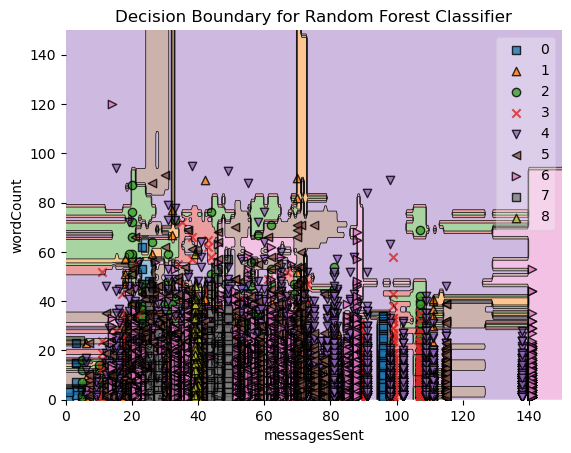

In [ ]:
from mlxtend.plotting import plot_decision_regions

# Plot decision boundary
plot_decision_regions(X.values, y.values, clf=clf, legend=1)
plt.xlabel('messagesSent')
plt.ylabel('wordCount')
plt.title('Decision Boundary for Random Forest Classifier')


plt.xlim(0, 150)
plt.ylim(0, 150)
plt.show()

/Users/emmakelsall/anaconda3/envs/ADSprojects/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


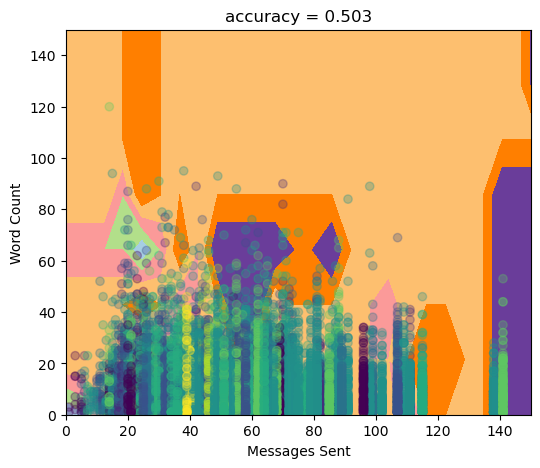

In [ ]:
from logitplots import plt_decision_boundaries

fig, ax = plt.subplots(figsize=(6,5)) 
xx, yy = np.meshgrid(np.linspace(0, 300), np.linspace(0, 1050))

plt_decision_boundaries(clf,xx,yy)

plt.scatter(x=X['messages_sent'], y=X['wordCount'], c=y, alpha=0.3)
plt.title('accuracy = {0}'.format(accuracy)) 
plt.xlabel('Messages Sent') 
plt.ylabel('Word Count'); 

plt.xlim(0, 150)
plt.ylim(0, 150)
plt.show()

In [ ]:

X = messages[['messages_sent']]

y = messages['OutcomeScore']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=42)
# instantatiate the RFC with 100 ensemble members
clf = RandomForestClassifier(n_estimators=50, max_samples=.5, random_state=42).fit(X_train, y_train)

y_pred = clf.predict(X_test) # calculate the predicted values
accuracy = np.round(accuracy_score(y_test, y_pred),3)
# print the accuracy of the RFC
print('Accuracy {0}'.format(accuracy))

rmse = mean_squared_error(y_test, y_pred, squared=False)
print('Mean squared error:', rmse)

r2 = r2_score(y_test, y_pred)
print("R^2: %.4f" % r2)

Accuracy 0.513
Mean squared error: 1.644723937121495


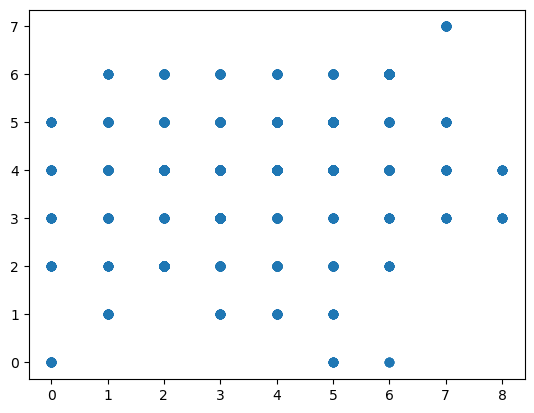

In [ ]:
plt.scatter(x=y_test, y=y_pred)

#### Combining the above with the Dummy Variables provided in Original data set 

In [ ]:
chatData = pd.read_csv('VI_data.csv', encoding='latin1')

# We have no interest in predicting Mentor OutcomeScore as these are always 4. 
# If kept in, will create a bias, therefore DROP. 

chatData = chatData[chatData['RoleName'] == 'Player']

# Drop every column except the chat content, the outcome score and word count
messages2 = chatData.drop(columns={'Unnamed: 0', 'implementation', 'Line_ID', 'ChatGroup', 'group_id', 'roomName', 'RoleName'})


# # Create a column for the number of messages each student sent: 
message_counts = messages2.groupby("userIDs")["content"].count().reset_index().rename(columns={'content':'messages_sent'})

messages2 = pd.merge(messages2, message_counts, on='userIDs')
messages2.head(10)

messages2['clean_text'] = messages2['content'].apply(preprocess_message)
messages2['sentimentScore'] = messages2['clean_text'].apply(get_sentiment_scores)

for keyword in keywords:
    messages2[f'{keyword}_frequency'] = messages2['content'].apply(lambda x: x.count(keyword))
    
messages2['tokens'] = messages2['clean_text'].apply(word_tokenize)

# Create a document-term matrix
dictionary = corpora.Dictionary(messages2['tokens'])
doc_term_matrix = [dictionary.doc2bow(doc) for doc in messages2['tokens']]

# Train the LDA model
num_topics = 10
lda_model = models.LdaModel(doc_term_matrix, num_topics=num_topics, id2word=dictionary)

topic_probs = pd.DataFrame(columns=['topic_{}'.format(i) for i in range(lda_model.num_topics)])

# Loop over each message and obtain its topic distribution probabilities
for index, row in messages2.iterrows():
    message = row['clean_text']
    bow_vector = lda_model.id2word.doc2bow(message.split())
    topic_distribution = lda_model.get_document_topics(bow_vector)
    
    # Fill in the corresponding topic probabilities for the current message
    probs_dict = dict(topic_distribution)
    topic_probs.loc[index] = [probs_dict.get(i, 0.0) for i in range(lda_model.num_topics)]

# Concatenate the topic probabilities DataFrame with the original DataFrame
df_with_topics = pd.concat([messages2, topic_probs], axis=1)


In [ ]:
all_features = df_with_topics.drop(columns={'OutcomeScore', 'content', 'clean_text', 'userIDs', 'tokens'})
all_features

,m_experimental_testing,m_making_design_choices,m_asking_questions,j_customer_consultants_requests,j_performance_parameters_requirements,j_communication,wordCount,messages_sent,sentimentScore,think_frequency,...,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0,0,0,0,0,0,4,65,0.00,0,...,0.034152,0.034151,0.034151,0.034152,0.034152,0.034159,0.034152,0.034152,0.034151,0.692628
1,0,0,1,0,0,0,13,65,0.00,0,...,0.019907,0.820866,0.019906,0.019903,0.019903,0.019904,0.019903,0.019903,0.019903,0.019903
2,0,0,0,0,0,0,8,65,0.00,0,...,0.025008,0.025002,0.774972,0.025001,0.025003,0.025005,0.025001,0.025003,0.025004,0.025002
3,0,0,1,0,0,0,8,65,0.00,0,...,0.025008,0.025002,0.774972,0.025001,0.025003,0.025005,0.025001,0.025003,0.025004,0.025002
4,0,0,0,0,0,0,30,65,-0.43,0,...,0.182627,0.000000,0.760168,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16897,0,0,0,0,0,0,2,72,0.00,0,...,0.050002,0.050001,0.050001,0.050001,0.050001,0.050001,0.050009,0.549984,0.050001,0.050001
16898,0,0,0,0,0,0,26,72,0.25,0,...,0.000000,0.000000,0.000000,0.116803,0.246183,0.000000,0.000000,0.000000,0.480176,0.109947
16899,0,0,0,0,0,0,16,72,0.00,0,...,0.014287,0.014292,0.557684,0.164983,0.014290,0.014289,0.014287,0.014287,0.177309,0.014292
16900,0,0,0,0,0,0,15,72,0.00,0,...,0.012501,0.411517,0.012504,0.322210,0.012501,0.012501,0.012504,0.012502,0.178758,0.012503


In [ ]:
y = messages2['OutcomeScore']

X_train, X_test, y_train, y_test = train_test_split(all_features, y, train_size=.8, random_state=42)
# instantatiate the RFC with 100 ensemble members
clf = RandomForestClassifier(n_estimators=50, random_state=42, max_depth=10, max_samples=.5).fit(X_train, y_train)

y_pred = clf.predict(X_test) # calculate the predicted values

accuracy = np.round(accuracy_score(y_test, y_pred),3)
# print the accuracy of the RFC
print('Accuracy {0}'.format(accuracy))

mse = mean_squared_error(y_test, y_pred, squared=False)
print('RMSE:', mse)

r2 = r2_score(y_test, y_pred)
print("R^2: %.4f" % r2)

Accuracy 0.39
RMSE: 1.5355397368183352
R^2: 0.0119


In [ ]:
y = messages2['OutcomeScore']

X_train, X_test, y_train, y_test = train_test_split(all_features, y, train_size=.8, random_state=42)
# instantatiate the RFC with 100 ensemble members
clf = DecisionTreeClassifier(random_state=42, max_depth=10).fit(X_train, y_train)

y_pred = clf.predict(X_test) # calculate the predicted values

accuracy = np.round(accuracy_score(y_test, y_pred),3)
# print the accuracy of the RFC
print('Accuracy {0}'.format(accuracy))

mse = mean_squared_error(y_test, y_pred, squared=False)
print('RMSE:', mse)

r2 = r2_score(y_test, y_pred)
print("R^2: %.4f" % r2)

Accuracy 0.507
RMSE: 1.5963578777405498
R^2: -0.0680


In [ ]:
row = {'no_estimators': 50, 'accuracy': accuracy}
for name, score in zip(all_features.columns, clf.feature_importances_):
    print(name,np.round(score,3))

m_experimental_testing 0.004
m_making_design_choices 0.0
m_asking_questions 0.003
j_customer_consultants_requests 0.0
j_performance_parameters_requirements 0.0
j_communication 0.0
wordCount 0.025
messages_sent 0.815
sentimentScore 0.015
think_frequency 0.002
agree_frequency 0.002
surfactant_frequency 0.0
steric_frequency 0.001
cost_frequency 0.003
prototype_frequency 0.004
flux_frequency 0.002
use_frequency 0.0
reliability_frequency 0.0
marketability_frequency 0.001
topic_0 0.012
topic_1 0.011
topic_2 0.016
topic_3 0.006
topic_4 0.013
topic_5 0.01
topic_6 0.014
topic_7 0.02
topic_8 0.01
topic_9 0.011


In [ ]:
X = all_features[['messages_sent', 'wordCount']]

y = messages['OutcomeScore']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=42)
# instantatiate the RFC with 100 ensemble members
clf = RandomForestClassifier(n_estimators=50, max_samples=.5, random_state=42).fit(X_train, y_train)

y_pred = clf.predict(X_test) # calculate the predicted values
accuracy = np.round(accuracy_score(y_test, y_pred),3)
# print the accuracy of the RFC
print('Accuracy {0}'.format(accuracy))

rmse = mean_squared_error(y_test, y_pred, squared=False)
print('RMSE:', rmse)

r2 = r2_score(y_test, y_pred)
print("R^2: %.4f" % r2)

Accuracy 0.503
Mean squared error: 1.689608443778028


In [ ]:
X = all_features[['messages_sent', 'wordCount']]

y = messages['OutcomeScore']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=42)
# instantatiate the RFC with 100 ensemble members
clf = DecisionTreeClassifier(random_state=42, max_depth=10).fit(X_train, y_train)

y_pred = clf.predict(X_test) # calculate the predicted values
accuracy = np.round(accuracy_score(y_test, y_pred),3)
# print the accuracy of the RFC
print('Accuracy {0}'.format(accuracy))

rmse = mean_squared_error(y_test, y_pred, squared=False)
print('RMSE:', rmse)

r2 = r2_score(y_test, y_pred)
print("R^2: %.4f" % r2)

Accuracy 0.508
Mean squared error: 1.5587669840293168


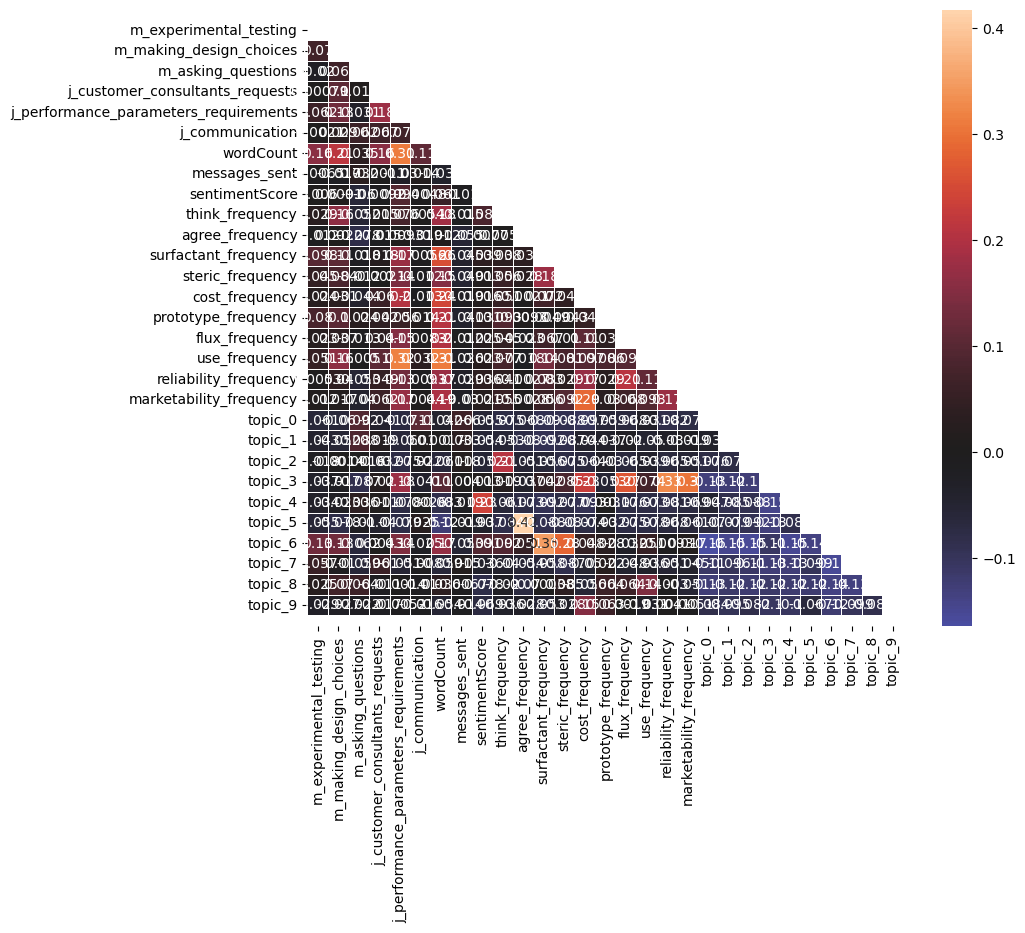

In [ ]:
from logitplots import plt_correlation_matrix

corrs = all_features.corr() # calculate the correlation table, first dropping the Class column
plt_correlation_matrix(corrs)

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

y = messages2['OutcomeScore']

X_train, X_test, y_train, y_test = train_test_split(all_features, y, train_size=.8, random_state=42)
# instantatiate the RFC with 100 ensemble members
clf = DecisionTreeClassifier(random_state=42, max_depth=10).fit(X_train, y_train)

y_pred = clf.predict(X_test) # calculate the predicted values

accuracy = np.round(accuracy_score(y_test, y_pred),3)
# print the accuracy of the RFC
print('Accuracy {0}'.format(accuracy))

mse = mean_squared_error(y_test, y_pred, squared=False)
print('RMSE:', mse)

r2 = r2_score(y_test, y_pred)
print("R^2: %.4f" % r2)

Accuracy 0.507
RMSE: 1.5963578777405498
R^2: -0.0680


In [ ]:
for name, score in zip(all_features.columns, clf.feature_importances_):
    print(name,np.round(score,3))

m_experimental_testing 0.004
m_making_design_choices 0.0
m_asking_questions 0.003
j_customer_consultants_requests 0.0
j_performance_parameters_requirements 0.0
j_communication 0.0
wordCount 0.025
messages_sent 0.815
sentimentScore 0.015
think_frequency 0.002
agree_frequency 0.002
surfactant_frequency 0.0
steric_frequency 0.001
cost_frequency 0.003
prototype_frequency 0.004
flux_frequency 0.002
use_frequency 0.0
reliability_frequency 0.0
marketability_frequency 0.001
topic_0 0.012
topic_1 0.011
topic_2 0.016
topic_3 0.006
topic_4 0.013
topic_5 0.01
topic_6 0.014
topic_7 0.02
topic_8 0.01
topic_9 0.011
